<a href="https://colab.research.google.com/github/Gooogr/Kaggle_Global_Wheat_Detection/blob/master/GWD_YOLO_v4_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc #garbage collector
import ast # operate with string representation of list
import os
import fnmatch
import re

import pandas as pd
import numpy as np
import cv2

from google.colab import files
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# create a symbolic sub-link to avoid 'space' problem
!ln -s /content/drive/My\ Drive/colab_notebooks/Kaggle_Global_Wheat_Detection/ /mydrive

In [4]:
# Enable GPU
# Check what we get: K80, P100, K4 or T4.
! nvidia-smi

Sat Jul 18 22:42:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# add kaggle.json key
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gooogr","key":"9984edb784f2ec4a2f5e02b2e4d12009"}'}

## Dataset downloading

In [6]:
 ! mkdir ~/.kaggle #inroot folder 
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle -v # reinstall kaggle API to fix bugs with data downloading

Kaggle API 1.5.4


In [8]:
! pip uninstall -y kaggle
! pip install --upgrade pip
! pip install -q kaggle==1.5.6
! kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 4.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.5 MB/s 
Kaggle API 1.5.6


In [9]:
! kaggle competitions download -c global-wheat-detection
! unzip -q global-wheat-detection.zip

 99% 601M/607M [00:05<00:00, 122MB/s]
100% 607M/607M [00:05<00:00, 123MB/s]


### Utilities

In [10]:
# def create_yolo_bbox(x):
#     x, y, width, height = list(map(int, ast.literal_eval(x)))
#     x_c = (x + width // 2) / 1024
#     y_c = (y + height // 2) / 1024
#     return ([x_c, y_c, (width / 1024), (height / 1024)])

# def write_yolo_txt(save_dir):
#     unique_ids = train_df['image_id'].unique()
#     for img_id in unique_ids:
#         df_sample = train_df[train_df['image_id'] == img_id]
#         temp_ser = df_sample['yolo_bbox']

#         file = open(os.path.join(save_dir, (img_id + ".txt")), "w")
#         for bbox in temp_ser:
#             row = ' '.join(str(item) for item in bbox)
#             file. write('0 ') #class number
#             file.write(row)
#             file.write('\n')
#         file.close()

def show_data_sample(dir_path):
  '''
  Show random sample from dataset with boundary box
  '''
  txt_files = []
  img_files = []
  for txt_file in os.listdir(dir_path):
      if fnmatch.fnmatch(txt_file, '*.txt'):
        txt_files.append(txt_file)
  print('Data pairs amount:', len(txt_files))

  sample_name = txt_files[np.random.randint(len(txt_files))].split('.')[0]

  txt_sample = open(os.path.join(dir_path, sample_name + '.txt'), 'r')
  img_sample = cv2.imread(os.path.join(dir_path, sample_name + '.jpg'))
  height = img_sample.shape[0]
  width = img_sample.shape[1]
  for line in txt_sample.readlines():
      #print(re.split('\s',line)[0:5])
      yolo_bndbox = (list(map(float, re.split('\s',line)[0:5])))
      voc_bndbox = yolo2voc(yolo_bndbox, width, height)
      img_sample = cv2.rectangle(img_sample, voc_bndbox[:2], voc_bndbox[2:], color=[255, 0, 0], thickness=2)
  img_sample = cv2.resize(img_sample, (0,0), fx=0.5, fy=0.5)  
  cv2_imshow(img_sample)


def yolo2voc(data, w, h):
  '''
  Convert boundary box from YOLO format to VOC
  '''
  bbox_width = float(data[3]) * w
  bbox_height = float(data[4]) * h
  center_x = float(data[1]) * w
  center_y = float(data[2]) * h
  x_min = int(center_x - (bbox_width / 2))
  y_min = int(center_y - (bbox_height / 2))
  x_max = int(center_x + (bbox_width / 2))
  y_max = int(center_y + (bbox_height / 2))
  return(x_min, y_min, x_max, y_max)

### Constants

In [11]:
MAIN_PATH = '/content/'
TRAIN_DIR_PATH = '/content/train'
TEST_DIR_PATH = '/content/test'

## Setting up YOLO Darknet

In [12]:
def make_darknet():
  '''
  Run this function if darknet wasn`t setted up your root project folder
  '''
  # Clone and  make darknet in My Drive folder. We should prepare all config files there befory copy them to tmp
  ! git clone https://github.com/AlexeyAB/darknet.git

  # Enable GPU learning
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/OPENMP=0/OPENMP=1/' Makefile

  # verify CUDA
  !/usr/local/cuda/bin/nvcc --version

  ! make --silent

In [13]:
%%capture
# Uncomment to make absense darknet from scratch 
make_darknet()

In [15]:
# Download pre-trained weights from google disk
!cp /mydrive/yolov4_naive_final.weights /content/ 
!mv  /content/yolov4_naive_final.weights /content/yolov4_predict.weights

### Prepare config files

In [ ]:
# # Create train and test(validate) txt files. Split ratio will be 0.1
# ! python3 splitTrainAndTest.py /content/train

In [16]:
! mkdir /content/yolo_config_files
% cd /content/yolo_config_files

/content/yolo_config_files


> obj.names

One class - one line. If you make a mistake in the order of the labels, the algorithm will work, but will incorrectly name the detected objects.

In [17]:
%%writefile obj.names
Wheat head

Writing obj.names


> yolo.data

Specify classes amount. Check pathes to other files:<br>
classses = *amount of your classes*<br>
valid  = /content/test.txt<br>
names = /content/yolo_config_files/obj.names<br>
backup = /content/yolo_weights<br>
train  = /content/train.txt<br>

During prediction only  ```names``` string is important.

In [45]:
% cd /content/yolo_config_files

/content/yolo_config_files


In [46]:
%%writefile yolo.data
#classses = 1
#valid = /content/test.txt
names = /content/yolo_config_files/obj.names
#backup = /content/yolo_weights
#train = /content/train.txt

Overwriting yolo.data


> yolov4.cfg

How to configure cfg file<br>
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

In [20]:
# #Generate anchors for cfg file
# # Can't open labels because of 49 files without bboxes
# % cd /content/darknet
# ! chmod 777 ./darknet
# ! ./darknet detector calc_anchors \
# /content/yolo_config_files/yolo.data -num_of_clusters 1 -width 608 -height 608 -show
# # Result - 50, 46

In [21]:
% cd /content/yolo_config_files/
! wget --quiet https://raw.githubusercontent.com/Gooogr/Kaggle_Global_Wheat_Detection/master/yolov4-custom.cfg \
-O /content/yolo_config_files/yolov4.cfg

/content/yolo_config_files


> predict.txt

File with pathes of predicting images.
Based on this [github post](https://github.com/pjreddie/darknet/issues/723#issuecomment-383332978)

In [ ]:
####################################################################

In [51]:
for root, dirs, files in os.walk(os.path.abspath("/content/test")):
    for file in files:
        print(os.path.join(root, file))

/content/test/53f253011.jpg
/content/test/51b3e36ab.jpg
/content/test/aac893a91.jpg
/content/test/348a992bb.jpg
/content/test/796707dd7.jpg
/content/test/cc3532ff6.jpg
/content/test/2fd875eaa.jpg
/content/test/f5a1f0358.jpg
/content/test/51f1be19e.jpg
/content/test/cb8d261a3.jpg


In [ ]:
def create_path_file(files_dir):
    # from https://stackoverflow.com/questions/9816816/get-absolute-paths-of-all-files-in-a-directory
    for root, dirs, files in os.walk(os.path.abspath("/content/test")):
        for file in files:
            print(os.path.join(root, file))


In [ ]:
###########################################################################

In [ ]:
# Safety measure to prevent yolo training start after massive pushing Shift + Enter
assert False

AssertionError: ignored

### Predict 

First, let's make predictions for  only one hardcoded picture

In [48]:
def predict_sample():
    %cd /content/darknet
    ! chmod 777 ./darknet

    ! ./darknet detector test \
    /content/yolo_config_files/yolo.data \
    /content/yolo_config_files/yolov4.cfg \
    /content/yolov4_predict.weights \
    /content/test/2fd875eaa.jpg 

    image = cv2.imread('predictions.jpg')
    image = cv2.resize(image, None, fx=0.5, fy=0.5)
    cv2_imshow(image)

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 

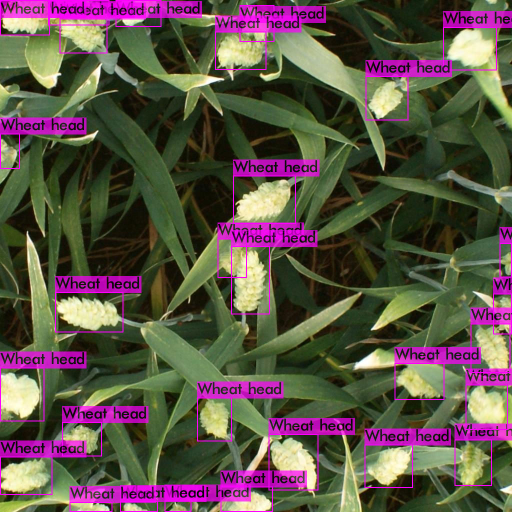

In [49]:
# check prediction sample
predict_sample()

Boundary box generator for complete test dataset